# Семинар 3. Scikit-learn. Метрические методы классификации. Оценка качества

## Проверочная работа

- Как найти скалярное произведение двух векторов $x$, $y$? Запишите формулу.
- Что такое переобучение?
- Какие способы оценки обобщающей способности вы знаете? Приведите 2 примера и кратко поясните, в чем они заключаются.


In [0]:
from matplotlib import pyplot as plt

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Вспомним про нормы

Норма обобщает понятие длины вектора, а вообще — это функция $\lVert x\rVert$, удовлетворяющая следующим условиям:
- если $\lVert x\rVert = 0$, то $x = 0$,

- $\lVert x + y \rVert \le \lVert x \rVert + \lVert y \rVert $ — неравенство треугольника

- $\lVert \alpha x \rVert \le |a|\cdot \lVert x \rVert$ (где $\alpha \in \mathbb{R}$).

$p$-норма вектора $z$ записывается как $\lVert z \rVert_p$ и равна:
\begin{equation}
    \|z\|_p = \biggl(\sum_i \lvert x_i\rvert^p\biggr)^\tfrac1{p}
\end{equation}
\begin{equation}
    \|z\|_\infty = \max_i |x_i|
\end{equation}

Для любого $p > 0$ такие функции удовлетворяют приведенным условиям. Изобразим линии уровня для $p \in \{ 0, 0.04, 0.5, 1, 1.5, 2, 7 \}$ и отдельно линию, где $\lVert x \rVert_p = 1$.

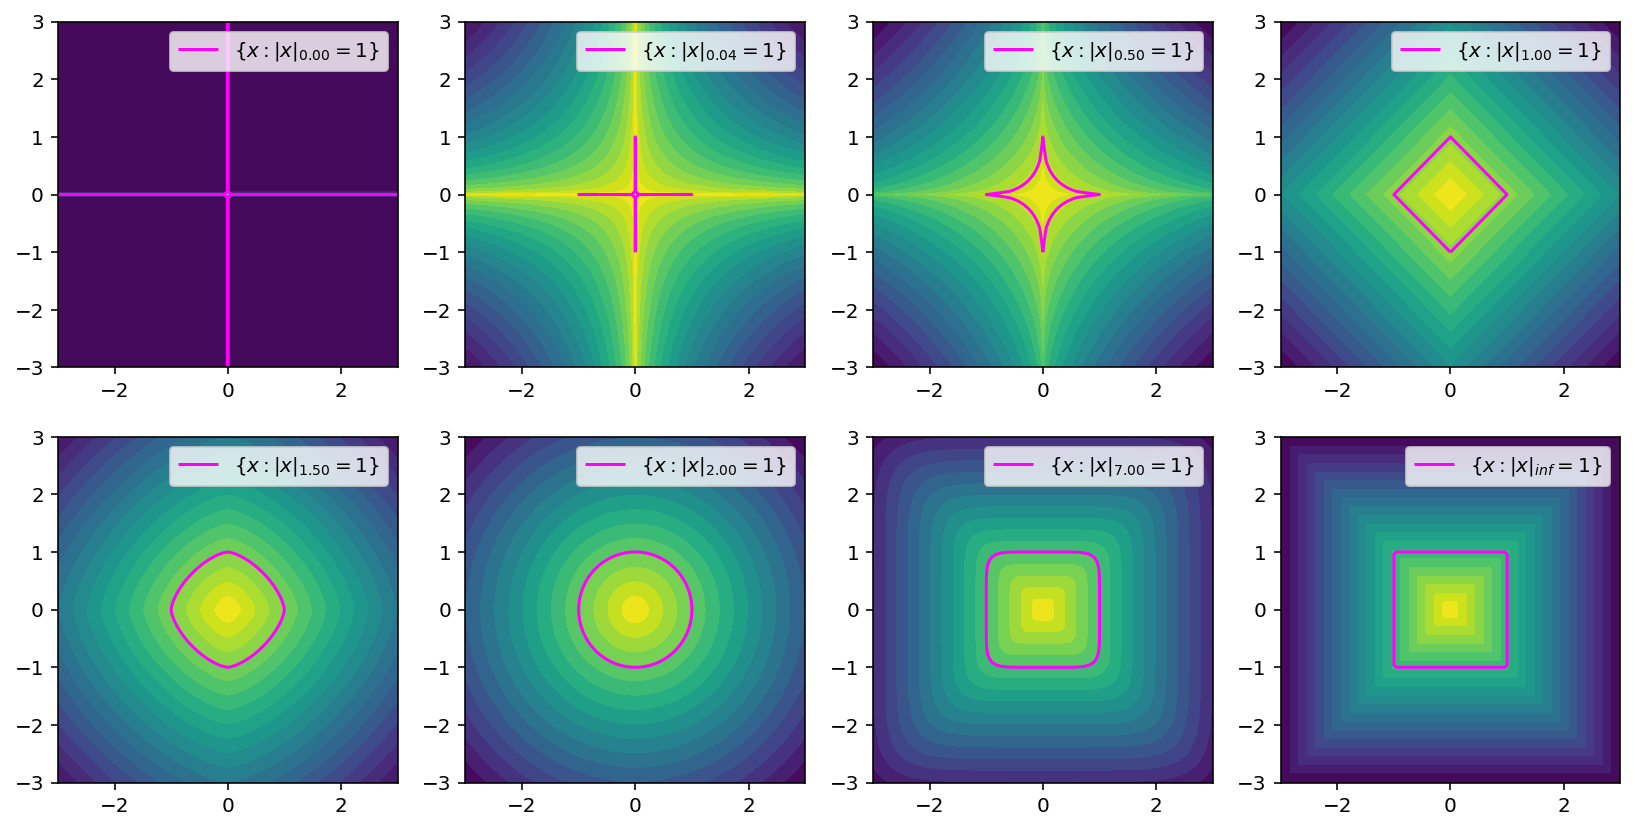

In [0]:
p_values = [0., 0.04, 0.5, 1, 1.5, 2, 7, np.inf]
xx, yy = np.meshgrid(np.linspace(-3, 3, num=101),
                     np.linspace(-3, 3, num=101))

fig, axes = plt.subplots(ncols=(len(p_values) + 1)// 2,
                         nrows=2, figsize=(14, 7))

for p, ax in zip(p_values, axes.flat):
    zz = np.linalg.norm(np.vstack((xx.flatten(), yy.flatten())).T, 
                        axis=1, ord=p).reshape((101, 101))
    ax.contourf(xx, yy, zz, cmap=plt.cm.viridis_r, levels=20)
    contour = ax.contour(xx, yy, zz, levels=[1], colors='magenta')
    contour.collections[0].set_label('$\{' + 'x: | x |_{' + f'{p:.2f}' + '} = 1\}$')
    ax.legend()

plt.show()

Фиолетовая линия на каждом графике показывает, где лежат все векторы «длины» $1$ (в соответствующей норме). Какие из этих норм вы уже знаете?

## Первый классификатор

В этом семинаре и а дальнейших частях курса мы будем много пользоваться алгоритмами из пакета Scikit-learn (сокращенно `sklearn`). В нем реализовано много алгоритмов машинного обучения для разных задач, и все они имеют очень похожий интерфейс, то есть пробовать и настраивать разные алгоритмы и их параметры очень легко. 

Сегодня мы посмотрим на его общие возможности на примере классификатора по $k$ ближайшим соседям и сравним несколько способов оценки качества.

In [0]:
from sklearn.datasets import make_moons

from mlxtend.plotting import plot_decision_regions

Создадим игрушечный датасет — набор точек на плоскости, которые образуют два класса в виде вложенных полумесяцев.

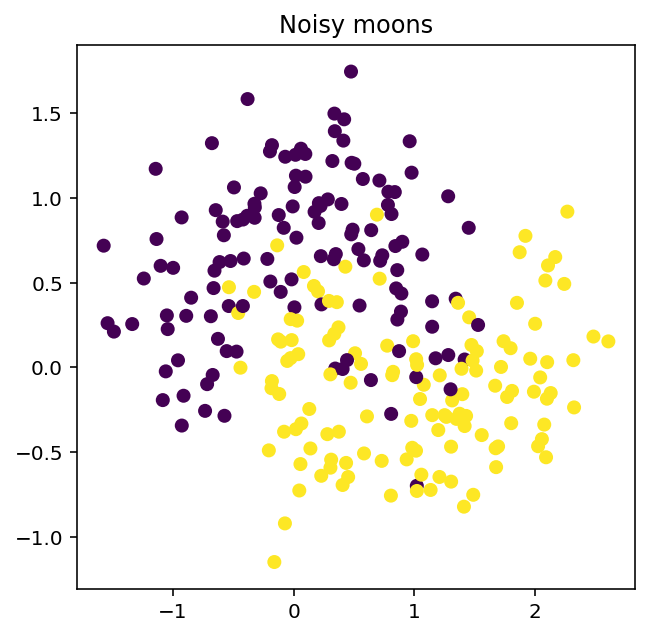

In [0]:
np.random.seed(8)

X, y = make_moons(250, noise=0.33)

plt.figure(figsize=(5, 5))
plt.title('Noisy moons')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Каждый алгоритм в `sklearn` — это класс, у объектов которого есть методы `.fit` и `.predict` или `.transform`. Параметры алгоритма, которые нельзя выбрать при обучении, задаются при создании модели:

In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

Чтобы обучить алгоритм на имеющейся выборке, необходимо вызвать у модели метод `.fit`:

In [0]:
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Текст выше еще раз напоминает, с какими параметрами мы обучили алгоритм. Что мы теперь можем сделать?

Получаем предсказания с помощью метода `.predict`:

In [0]:
knn.predict(X)

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1])

Как оценить, насколько хороши эти предсказания? Например, посчитать accuracy:

In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y, knn.predict(X))  # сначала настоящие классы, потом предсказанные

0.912

Посмотреть на решающую поверхность:

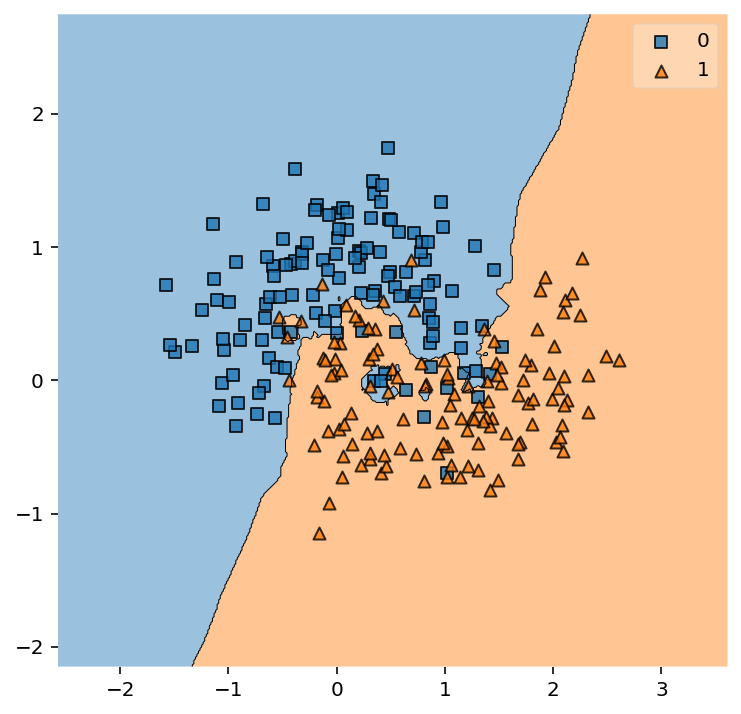

In [0]:
plt.figure(figsize=(6, 6))
plot_decision_regions(X, y, knn)
plt.show()

Все ли мы сделали правильно? Что если бы мы выбрали не 5 ближайших соседей, а одного?

In [0]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
accuracy_score(y, knn.predict(X))

1.0

100% верных предсказаний, разве не хорошо?

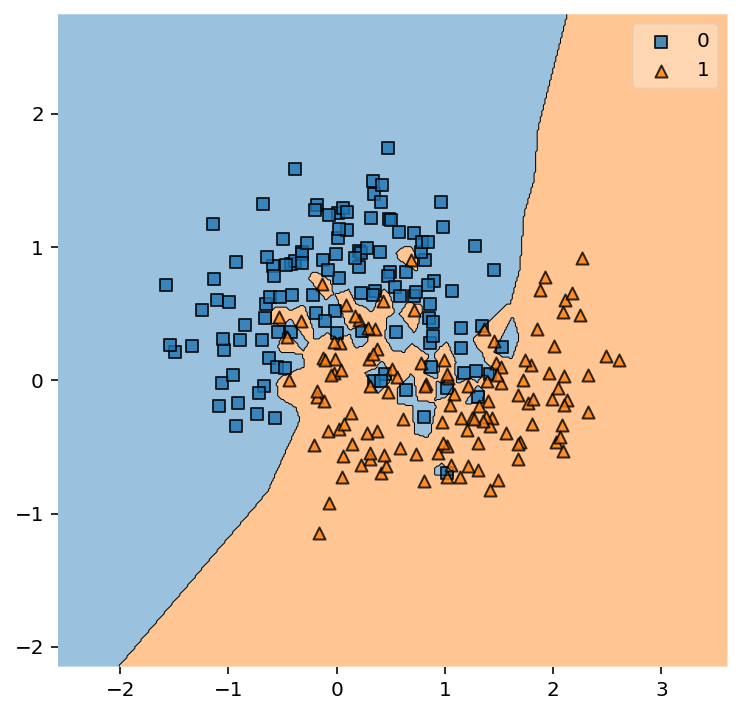

In [0]:
plt.figure(figsize=(6, 6))
plot_decision_regions(X, y, knn)
plt.show()

Можно заметить, что решающая поверхность сильно искажается от наличия объектов, которые близки к объектам другого класса. Как алгоритм будет работать с новыми данными из такого же распределения?

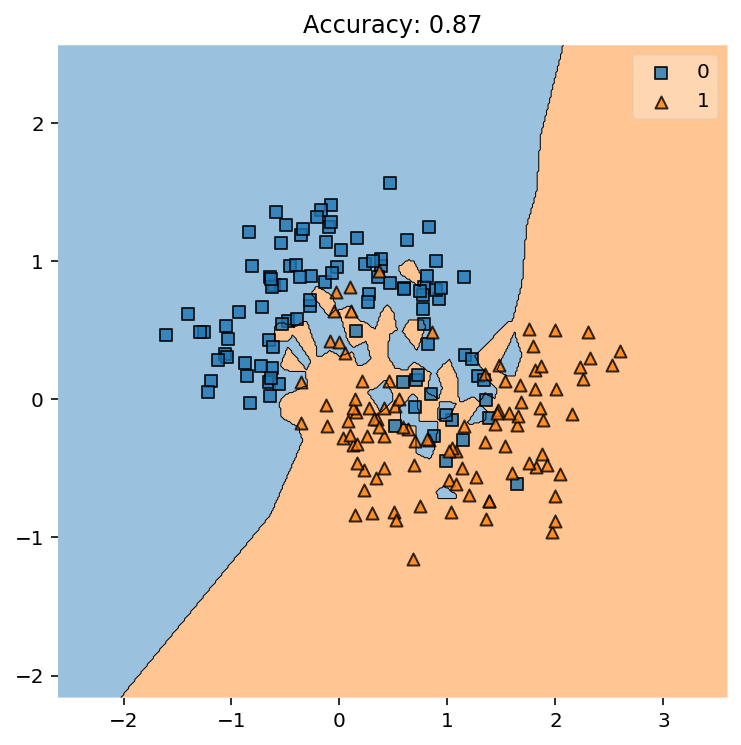

In [0]:
X_new, y_new = make_moons(200, noise=0.33)

plt.figure(figsize=(6, 6))
plot_decision_regions(X_new, y_new, knn)
plt.title('Accuracy: ' + str(accuracy_score(y_new, knn.predict(X_new))))

plt.show()

Качество испортилось, но это было ожидаемо. Когда мы рассматриваем только одного ближайшего соседа, очевидно, что это сам объект, поэтому на данных, где мы обучали такой KNN, мы будем видеть точность в 100%. 

KNN запоминает выборку в точности, но и многие другие алгоритмы могут запоминать особенности обучающей выборки. Поэтому важно оценивать не столько то, как хорошо мы описали данные, но обобщающую способность.

## Отложенная выборка. Подбор гиперпараметра $k$ 

Идея — можем отложить часть выборки, чтобы проверять модель на ней. При этом они не должны попасть в обучающую выборку. В `sklearn` есть удобный инструмент для разделения выборки — `train_test_split`.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

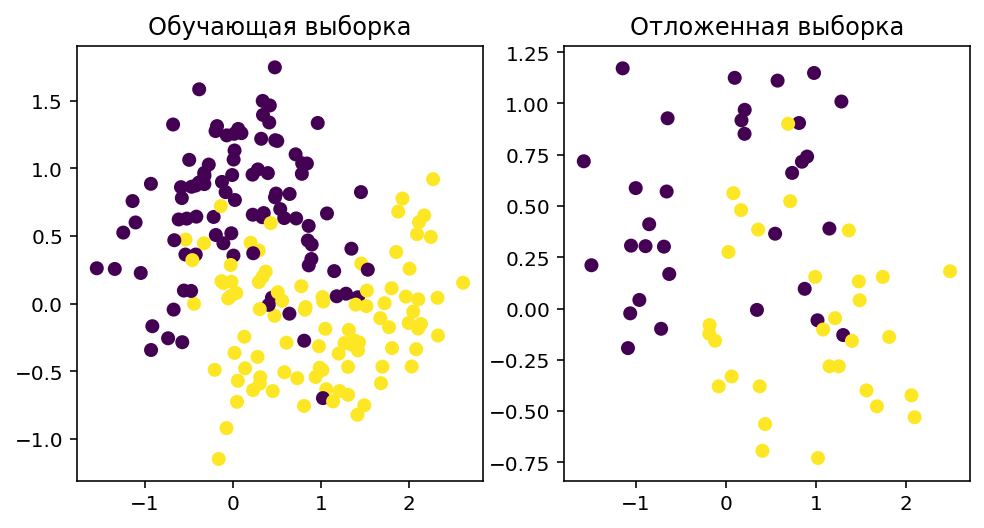

In [0]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title('Обучающая выборка')

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.title('Отложенная выборка')

plt.show()

Чем нам поможет обучающая выборка? Давайте снова обучим KNN с одним ближайшим соседом и проверим качество на обучающей и отложенной выборке и на новых данных:

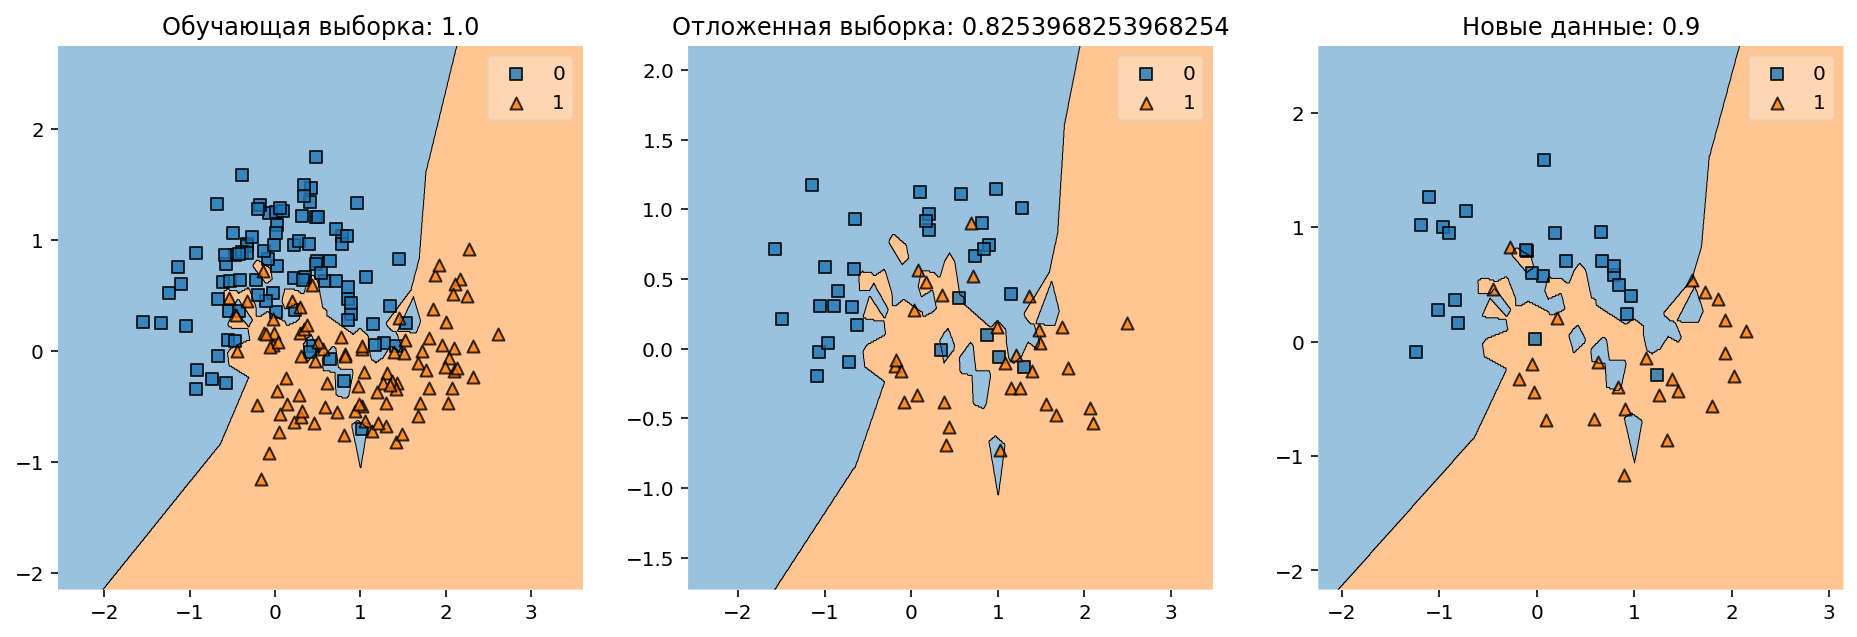

In [0]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plot_decision_regions(X_train, y_train, knn)
plt.title('Обучающая выборка: ' + str(accuracy_score(y_train, knn.predict(X_train))))

plt.subplot(1, 3, 2)
plot_decision_regions(X_test, y_test, knn)
plt.title('Отложенная выборка: ' + str(accuracy_score(y_test, knn.predict(X_test))))

X_new, y_new = make_moons(50, noise=0.33)
plt.subplot(1, 3, 3)
plot_decision_regions(X_new, y_new, knn)
plt.title('Новые данные: ' + str(accuracy_score(y_new, knn.predict(X_new))))

plt.show()

Хотя в этом случае оценка на тестовой выборке и оказалась достаточно пессимистичной, но мы сразу поняли, что алгоритм неидеален — получается, действительно оценивать качество по обучающей выборке — плохая идея, а на отложенной — хорошая, и на этом примере мы это увидели.

Какое значение $k$ лучше выбрать? Попробуем простой перебор от $1$ до $12$:

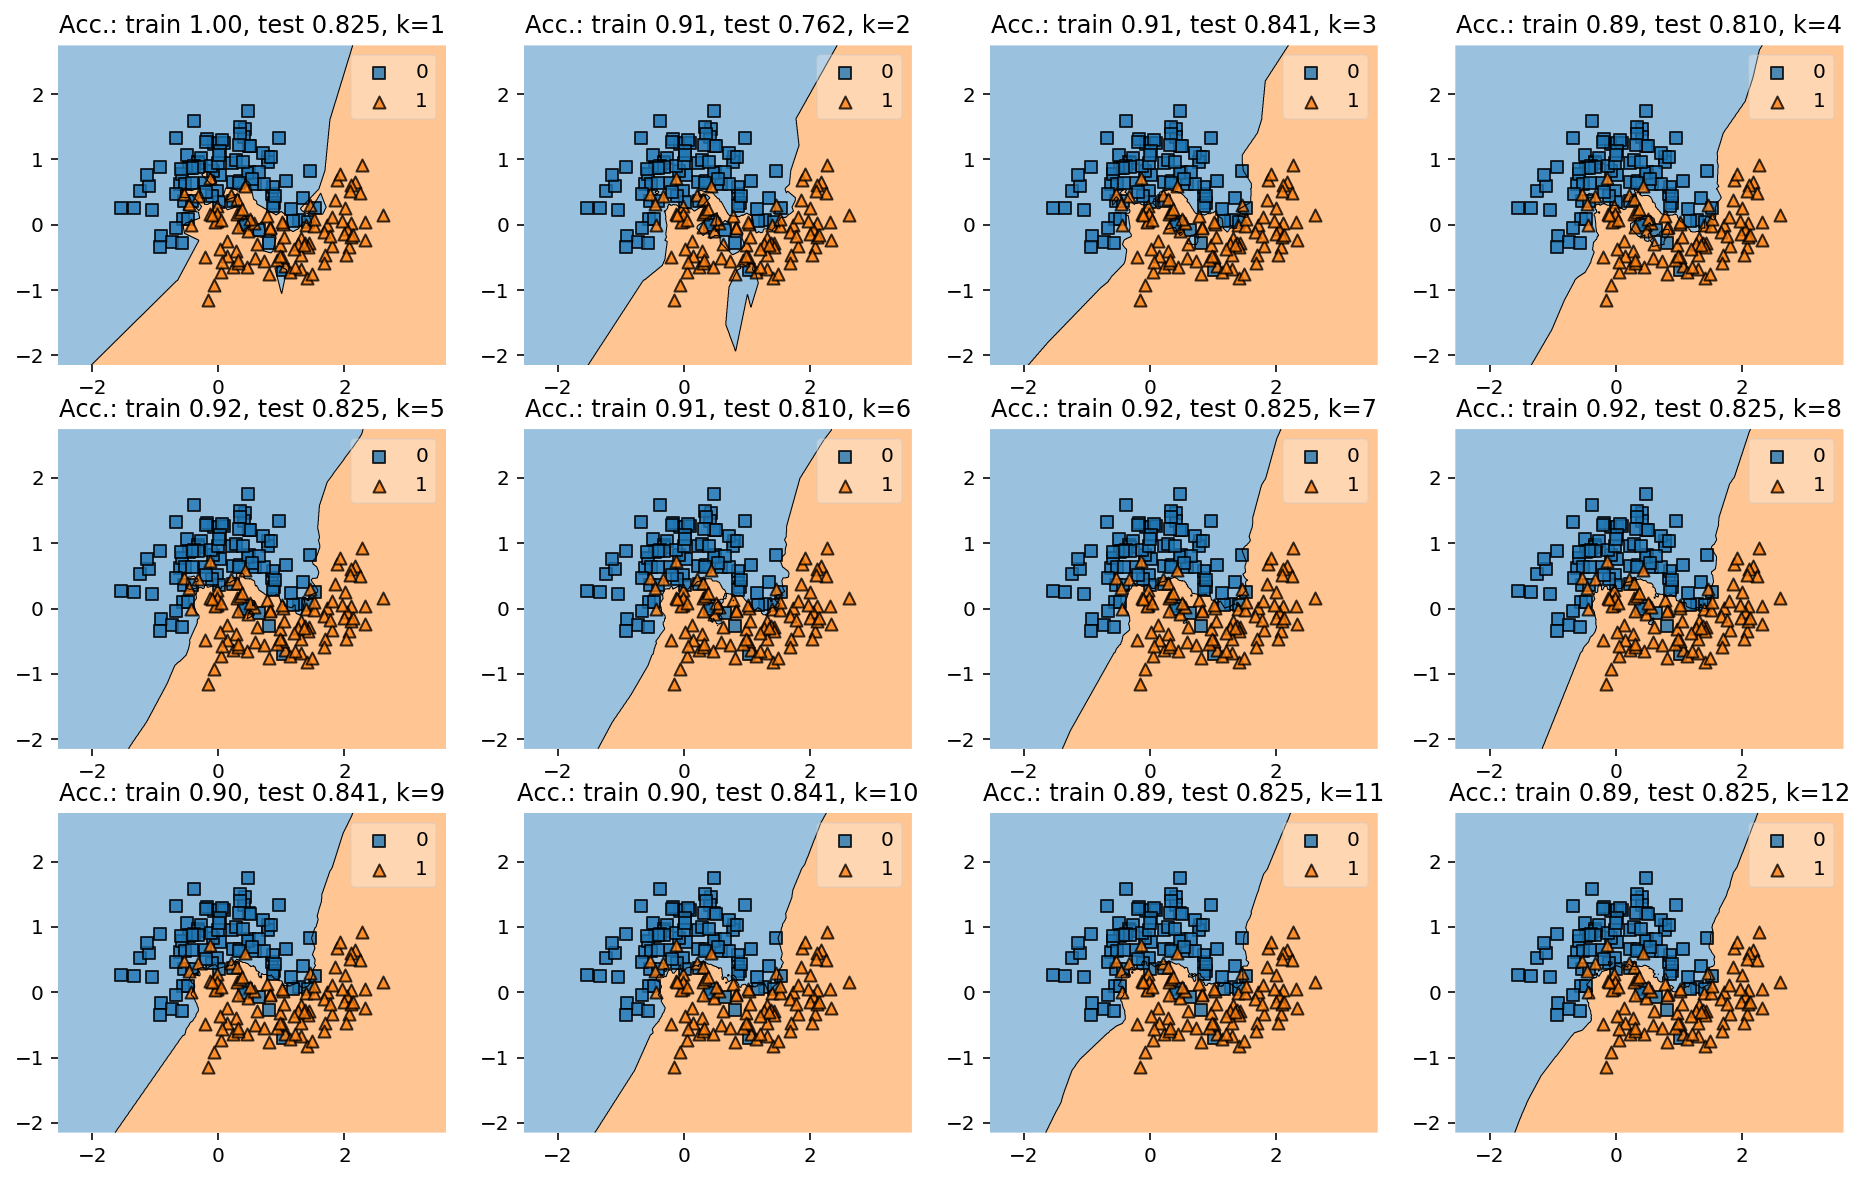

In [0]:
k_candidates = list(range(1, 13))

plt.figure(figsize=(16, 10))

for k in k_candidates:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    train_accuracy = accuracy_score(y_train, knn.predict(X_train))
    test_accuracy = accuracy_score(y_test, knn.predict(X_test))

    plt.subplot(3, 4, k)
    plot_decision_regions(X_train, y_train, knn)
    title = f'Acc.: train {train_accuracy:.2f}, test {test_accuracy:.3f}, k={k}'
    plt.title(title)

plt.show()

Но что если в самой отложенной выборке оказались особенные объекты (например, почти полностью из одного класса)?

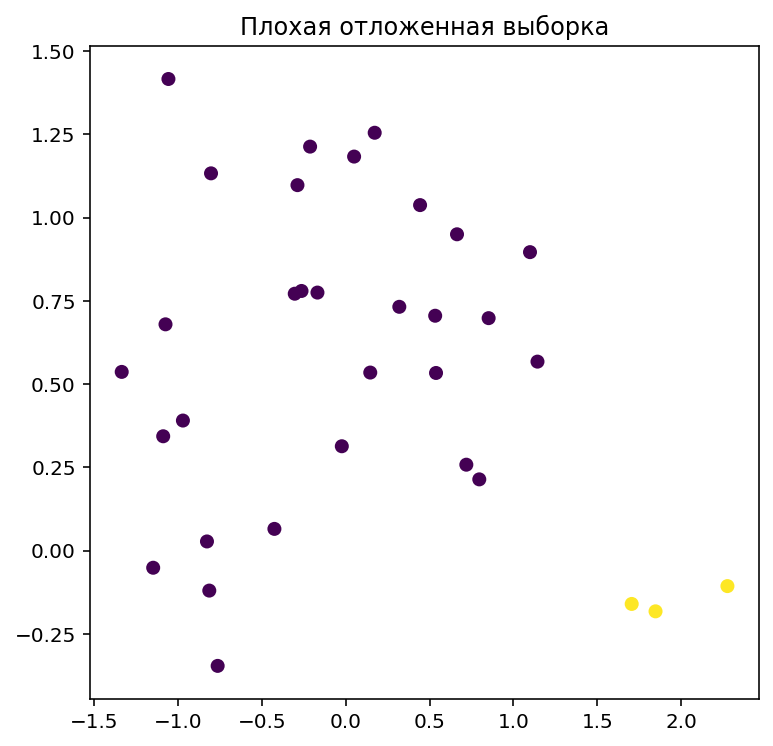

In [0]:
X_strange, y_strange = make_moons(100, noise=0.35)
idxs = np.argsort(y_strange)

X_strange = X_strange[idxs[20:53]]
y_strange = y_strange[idxs[20:53]]

plt.figure(figsize=(6, 6))
plt.scatter(X_strange[:, 0], X_strange[:, 1], c=y_strange)
plt.title('Плохая отложенная выборка')
plt.show()

## Кросс-валидация

Идея — строим обучающую и отложенную выборку не по одному, а по нескольким разбиениям датасета, для каждой пары обучаем алгоритм, замеряем метрики на тестовой выборке, затем усредняем по разбиениям.

Плюсы:

+ Избавляемся от проблемы особенной тестовой выборки
+ Получаем более случайную симуляцию новых данных

Минусы:

- Долгий перебор разбиений, не всегда можем себе позволить

В `sklearn` для этого тоже предусмотрели очень простую функцию. Пример:

In [0]:
from sklearn.model_selection import cross_val_score, KFold

In [0]:
fold = KFold(n_splits=5, random_state=5)

knn = KNeighborsClassifier(n_neighbors=9)

scores = cross_val_score(knn, X, y, cv=fold, scoring='accuracy')
scores

array([0.86, 0.82, 0.94, 0.86, 0.9 ])

In [0]:
np.mean(scores)

0.876

Теперь сделаем то же, что в прошлом разделе, но с кросс-валидацией.

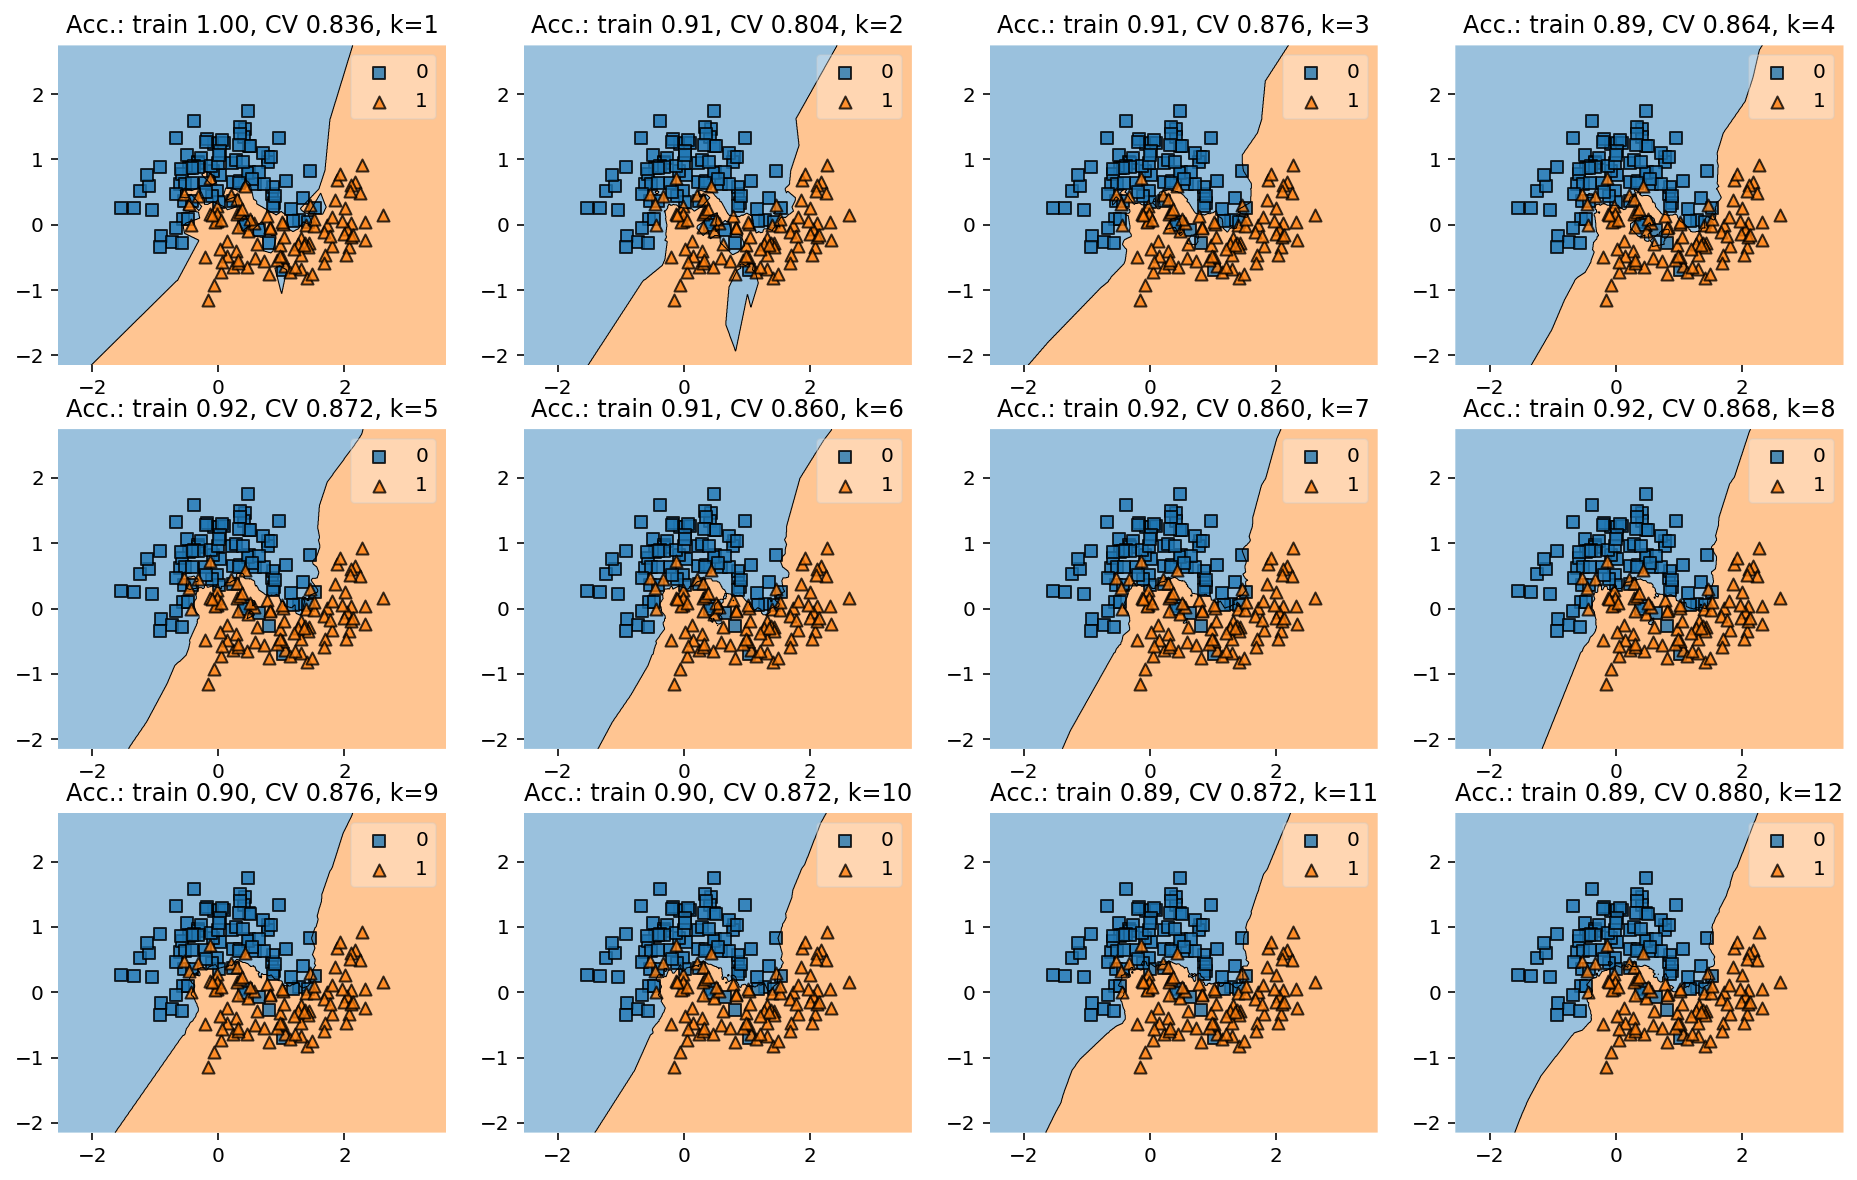

In [0]:
k_candidates = list(range(1, 13))

plt.figure(figsize=(16, 10))

for k in k_candidates:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    train_accuracy = accuracy_score(y_train, knn.predict(X_train))
    cv_accuracy = np.mean(cross_val_score(knn, X, y, cv=fold, scoring='accuracy'))

    plt.subplot(3, 4, k)
    plot_decision_regions(X_train, y_train, knn)
    title = f'Acc.: train {train_accuracy:.2f}, CV {cv_accuracy:.3f}, k={k}'
    plt.title(title)

plt.show()

## KNN с другими метриками и весами

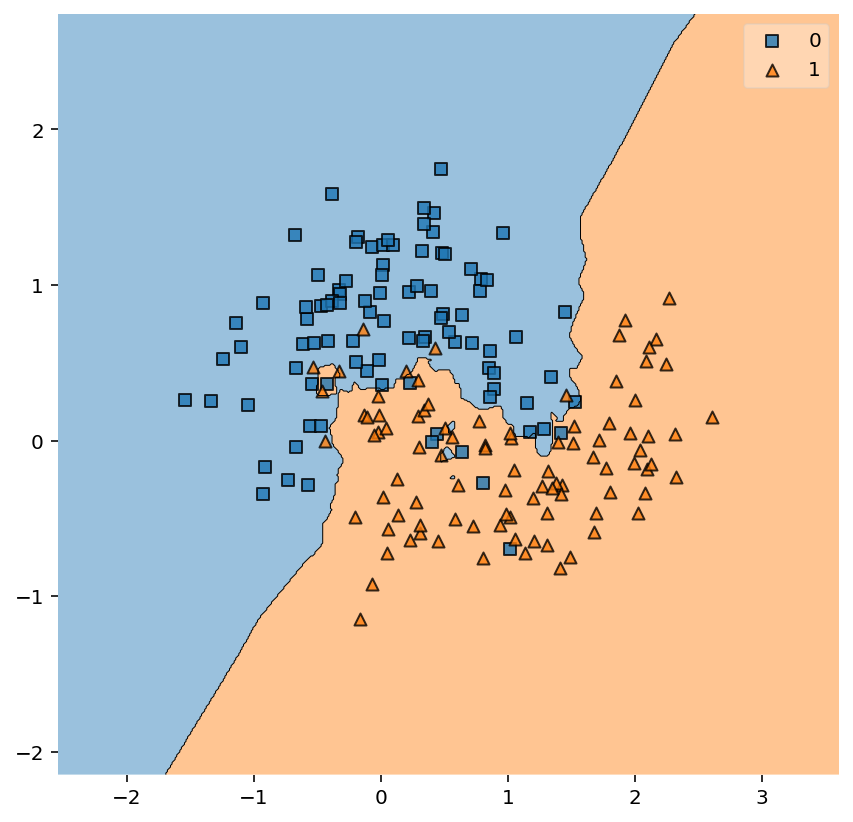

In [0]:
knn = KNeighborsClassifier(n_neighbors=5, p=3)
knn.fit(X_train, y_train)

plt.figure(figsize=(7, 7))
plot_decision_regions(X_train, y_train, knn)
plt.show()

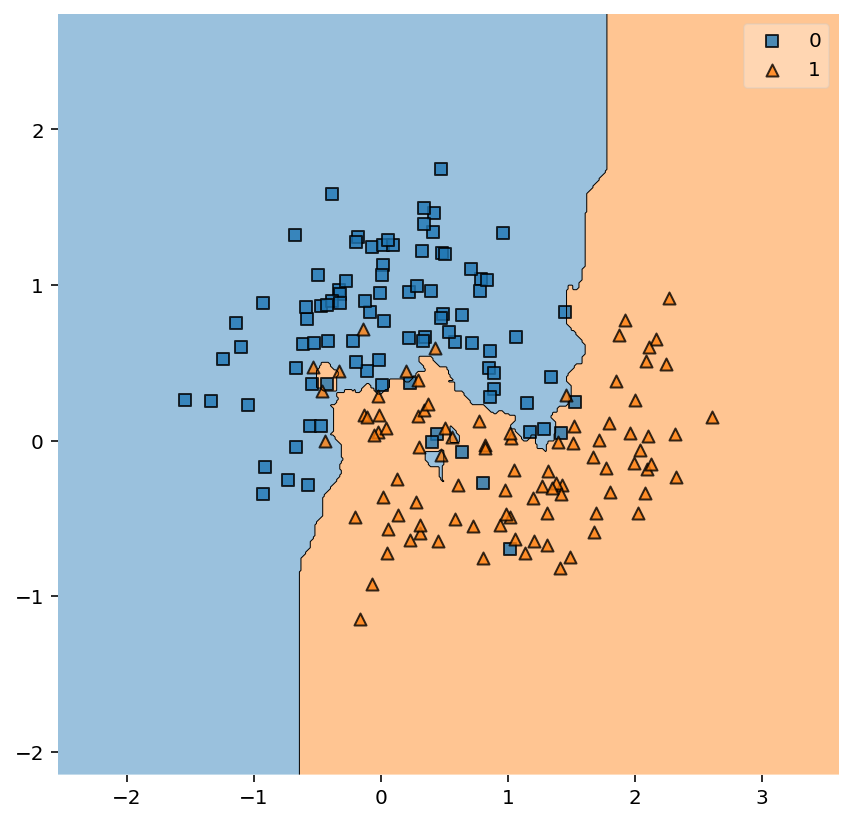

In [0]:
knn = KNeighborsClassifier(n_neighbors=5, p=1)
knn.fit(X_train, y_train)

plt.figure(figsize=(7, 7))
plot_decision_regions(X_train, y_train, knn)
plt.show()

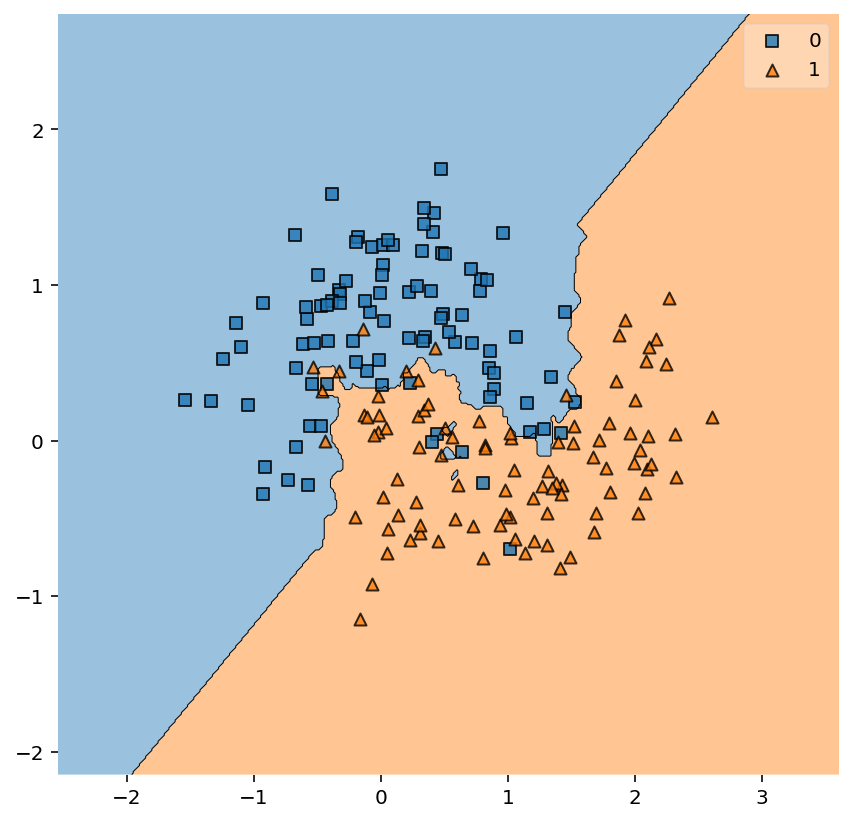

In [0]:
knn = KNeighborsClassifier(n_neighbors=5, p=100)
knn.fit(X_train, y_train)

plt.figure(figsize=(7, 7))
plot_decision_regions(X_train, y_train, knn)
plt.show()

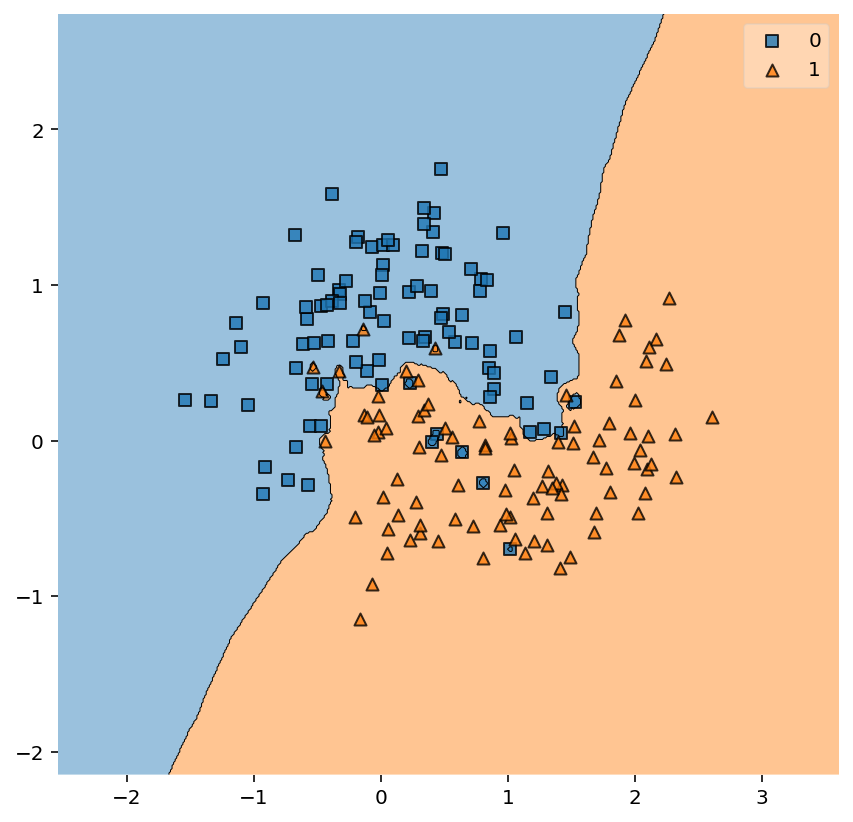

In [0]:
knn = KNeighborsClassifier(n_neighbors=12, weights='distance')
knn.fit(X_train, y_train)

plt.figure(figsize=(7, 7))
plot_decision_regions(X_train, y_train, knn)
plt.show()

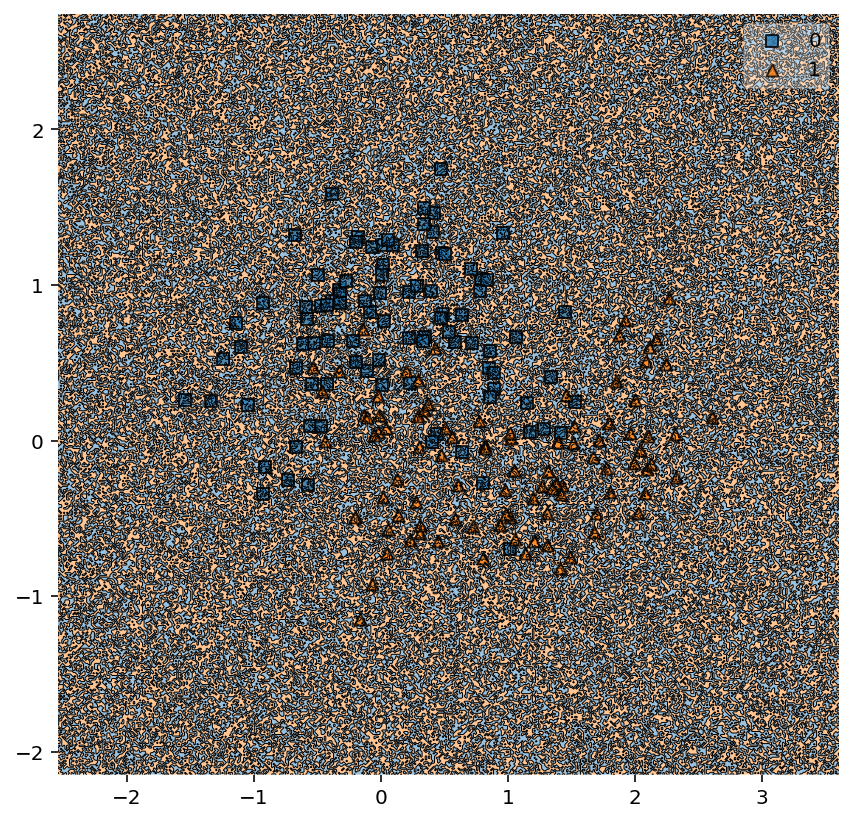

In [0]:
def random(arr):
    return np.random.random(arr.shape) * np.random.random(arr.shape)

knn = KNeighborsClassifier(n_neighbors=187, weights=random)
knn.fit(X_train, y_train)

plt.figure(figsize=(7, 7))
plot_decision_regions(X_train, y_train, knn)
plt.show()

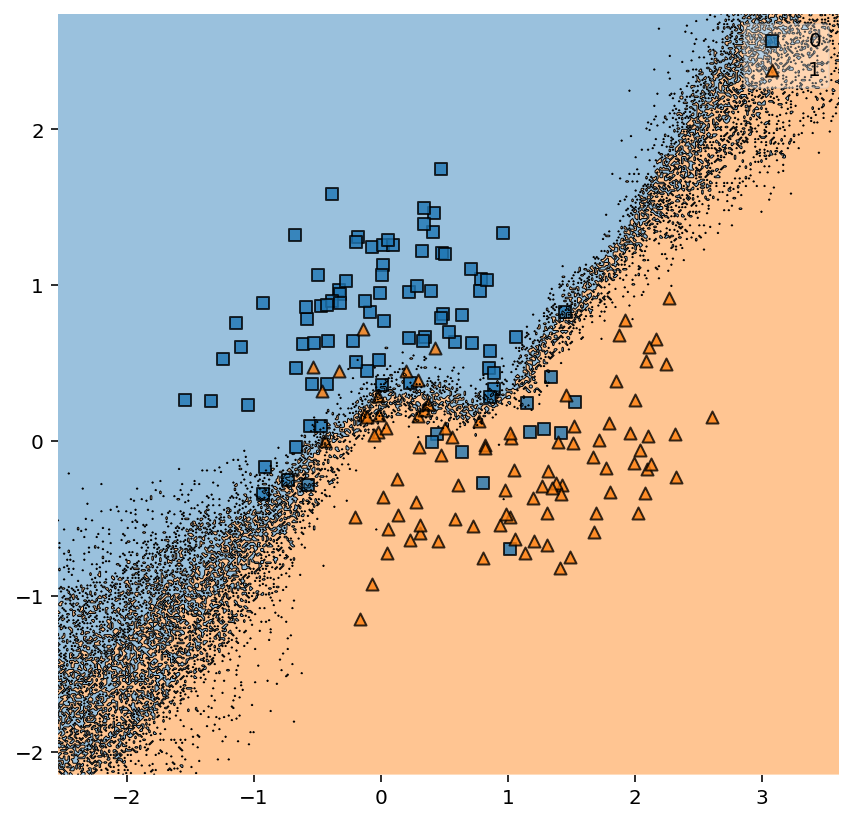

In [0]:
def random(arr):
    return np.random.random(arr.shape) * np.random.random(arr.shape)

knn = KNeighborsClassifier(n_neighbors=50, weights=random)
knn.fit(X_train, y_train)

plt.figure(figsize=(7, 7))
plot_decision_regions(X_train, y_train, knn)
plt.show()

## Пишем свой KNN

In [0]:
class NaiveKNeighborsClassifier:
    def __init__(n_neighbors=5):
        self._n_neighbors = n_neighbors
        self._saved_X = None

    def fit(X, y):
        self.saved_X = X
        self.saved_y = y

    def predict(X):
        neighbor_indices = np.argpartition(-X @ self.saved_X, self._n_neighbors)[:, :self._n_neighbors]
        return 

In [0]:
import numpy as np

In [0]:
x1 = np.random.random((10, 5))
x1 /= np.linalg.norm(x1, axis=1, keepdims=True)
x2 = np.random.random((20, 5))
x2 /= np.linalg.norm(x2, axis=1, keepdims=True)

In [0]:
np.argpartition(-x1 @ x1.T, 5)[:, :5]

array([[1, 0, 6, 9, 5],
       [5, 0, 6, 3, 1],
       [2, 7, 3, 5, 9],
       [3, 7, 5, 6, 2],
       [6, 4, 9, 8, 7],
       [3, 5, 6, 7, 9],
       [5, 9, 6, 4, 7],
       [7, 3, 5, 6, 2],
       [6, 9, 8, 7, 4],
       [6, 9, 4, 5, 7]])

In [0]:
y = np.random.randint(0, 2, (10, ))

In [0]:
y

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1])

In [0]:
y[np.argpartition(-x1 @ x1.T, 5)[:, :5]]

array([[1, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [1, 0, 1, 0, 1],
       [1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0],
       [1, 0, 1, 0, 1],
       [0, 1, 1, 1, 0],
       [0, 1, 0, 1, 1],
       [1, 1, 0, 0, 1],
       [1, 1, 1, 0, 0]])

In [0]:
import pickle

In [0]:
pickle.dumps(NaiveKNeighborsClassifier.fit)

b'\x80\x03cbuiltins\ngetattr\nq\x00c__main__\nNaiveKNeighborsClassifier\nq\x01X\x03\x00\x00\x00fitq\x02\x86q\x03Rq\x04.'